# Hace tu visualizacion!
> Después del último post varias personas se acercaron con ideas para probar...

- toc: false 
- badges: true
- comments: false
- categories: [tutorial]
- image: images/infected-and-growth.png

... asi que aqui vamos!

Para los posts anteriores utilicé los **datos** de la universidad de [Johns Hopkins](https://github.com/CSSEGISandData/COVID-19) y los [datos publicados nacionales](https://www.argentina.gob.ar/coronavirus/informe-diario), que a diferencia de los de Johns Hopkins, está abierta por provincias

Los datos abiertos por provincias provienen de un **scrapper que la saca de los PDFs**. Los primeros informes no seguian un patron tan sencillo para extraer, y luego estandarizaron en una enumeracion. Como los casos de los primeros informes eran unos pocos, el scrapper los desestima.

En este post, intencionalmente **no oculté las celdas**. 

En las notebooks de otros posts oculté el código por una cuestion de legibilidad. Si entran en [este](https://github.com/elsonidoq/covid-19-argentina/blob/master/_notebooks/2020-03-24-visualizando-los-datos-del-informe-diario.ipynb), van a ver dice `#hide` en muchas cells. Eso hace que se oculte al hacer el post

Para ver la documentación sobre como colaborar, pueden ir a [fastpages](https://fastpages.fast.ai/).


In [1]:
# voy a usar tanto matplotlib, altair y seaborn... porque se puede!
%matplotlib inline
import matplotlib.pyplot as plt
import altair as alt
import seaborn as sns
import pandas as pd
import numpy as np

# Estos files estan en el repo
import arg_data
import global_data

sns.set(style='whitegrid')

## Cargamos los dataframes

In [2]:
# Baja los PDFs, los guarda en la carpeta cache y los lee
arg_df = arg_data.get_arg_df()

# Accede a la data de JH
global_df = global_data.get_global_covid_df()

Processing cache/9-07-20_reporte_vespertino_covid_19.pdf...
	Has 25 matches
Processing cache/8-07-20_reporte_vespertino_covid_19.pdf...
	Has 25 matches
Processing cache/06-07-20_reporte-vespertino_covid-19.pdf...


	Has 24 matches
Processing cache/05-07-20-reporte-vespertino-covid-19.pdf...
	Has 25 matches
Processing cache/04-07-20_reporte-vespertino_covid-19.pdf...


	Has 26 matches
Processing cache/3-07-20-reporte-vespertino-covid-19.pdf...
	Has 25 matches
Processing cache/02-07-20-reporte-vespertino-covid-19.pdf...
	Has 25 matches
Processing cache/1-07-20_reporte_vespertino_covid_19.pdf...


	Has 25 matches
Processing cache/30-06-20-reporte-vespertino-covid-19.pdf...
	Has 25 matches
Processing cache/29-06-20-reporte-vespertino-covid-19.pdf...
	Has 25 matches
Processing cache/28-06-20-reporte-vespertino-covid-19.pdf...


	Has 24 matches
Processing cache/27-06-20_reporte_vespertino_covid-19.pdf...
	Has 24 matches
Processing cache/26-06-20-reporte-vespertino-covid-19.pdf...
	Has 25 matches


Processing cache/25-06-20-reporte-vespertino-covid-19.pdf...
	Has 25 matches
Processing cache/24-06-20_reporte_vespertino_covid_19.pdf...
	Has 23 matches
Processing cache/23-06-20_reporte_vespertino_covid_19.pdf...


	Has 25 matches
Processing cache/22-06-20-reporte-vespertino-covid-19_0.pdf...
	Has 24 matches
Processing cache/21-06-20_reporte-vespertino-covid-19.pdf...
	Has 25 matches


Processing cache/20-06-20_reporte_vespertino_covid_19.pdf...
	Has 1 matches
Processing cache/19-06-20_reporte_vespertino_covid_19.pdf...
	Has 24 matches
Processing cache/18-06-20_reporte_vespertino_covid_19.pdf...


	Has 25 matches
Processing cache/17-06-20_reporte_vespertino_covid_19.pdf...
	Has 25 matches
Processing cache/16-06-20-reporte-vespertino-covid-19.pdf...
	Has 24 matches
Processing cache/15-06-20_reporte-vespertino_covid-19.pdf...


	Has 25 matches
Processing cache/14-06-20_reporte-vespertino_covid-19.pdf...
	Has 25 matches
Processing cache/13-06-20_reporte_vespertino_covid_19.pdf...
	Has 24 matches
Processing cache/12-06-20_reporte_vespertino_covid_19.pdf...


	Has 1 matches
Processing cache/11-06-20_reporte_vespertino_covid_19.pdf...
	Has 24 matches
Processing cache/10-06-20-reporte-vespertino-covid-19.pdf...
	Has 25 matches
Processing cache/9-06-20-reporte-vespertino-covid-19.pdf...


	Has 25 matches
Processing cache/8-06-20-reporte-vespertino-covid-19.pdf...
	Has 24 matches
Processing cache/07-06-20-reporte-vespertino-covid-19.pdf...
	Has 21 matches
Processing cache/06-06-20_reporte-vespertino_covid-19.pdf...


	Has 24 matches
Processing cache/5-06-20_reporte_vespertino_covid_19.pdf...
	Has 25 matches
Processing cache/04-06-20_reporte-vespertino_covid-19.pdf...
	Has 25 matches
Processing cache/3-06-20-reporte-vespertino-covid-19.pdf...


	Has 25 matches
Processing cache/02-06-20_reporte-vespertino_covid-19.pdf...
	Has 25 matches
Processing cache/1-06-20_reporte_vespertino_covid_19.pdf...


	Has 24 matches
Processing cache/31-05-20_reporte_vespertino_covid_19.pdf...
	Has 25 matches
Processing cache/30-05-20_reporte_vespertino_covid_19.pdf...
	Has 0 matches
Processing cache/29-05-20-reporte-vespertino-covid-19.pdf...
	Has 26 matches


Processing cache/28-05-20_reporte_vespertino_covid_19.pdf...
	Has 0 matches
Processing cache/27-05-20_reporte_vespertino_covid_19.pdf...
	Has 26 matches
Processing cache/26-05-20-reporte-vespertino-covid-19.pdf...
	Has 26 matches


Processing cache/25-05-20_reporte_vespertino_covid_19.pdf...
	Has 25 matches
Processing cache/24-05-20-reporte-vespertino-covid-19.pdf...
	Has 24 matches
Processing cache/23-05-20_reporte_vespertino_covid_19.pdf...


	Has 26 matches
Processing cache/22-05-20_reporte-vespertino_covid-19.pdf...
	Has 26 matches
Processing cache/21-05-20_reporte_vespertino_covid_19.pdf...
	Has 1 matches
Processing cache/20-05-20-reporte-vespertino-covid-19.pdf...


	Has 26 matches
Processing cache/19-05-20_reporte_vespertino_covid_19.pdf...
	Has 26 matches
Processing cache/18-05-20_reporte_vespertino_covid_19.pdf...
	Has 0 matches
Processing cache/17-05-20_reporte_vespertino_covid_19.pdf...


	Has 0 matches
Processing cache/16-05-20_reporte_vespertino_covid_19.pdf...
	Has 26 matches
Processing cache/15-05-20_reporte_vespertino_covid_19.pdf...
	Has 26 matches
Processing cache/14-05-20_reporte_vespertino_covid_19.pdf...


	Has 1 matches
Processing cache/13-05-20_reporte_vespertino_covid_19.pdf...
	Has 26 matches
Processing cache/12-05-20_reporte_vespertino_covid_19.pdf...
	Has 26 matches
Processing cache/11-05-20-reporte-vespertino-covid-19.pdf...


	Has 26 matches
Processing cache/10-05-20-reporte-vespertino-covid-19.pdf...
	Has 26 matches
Processing cache/09-05-20_reporte-vespertino_covid-19.pdf...
	Has 25 matches
Processing cache/08-05-20_reporte-vespertino-covid-19.pdf...


	Has 26 matches
Processing cache/07-05-20_reporte_vespertino_covid_19.pdf...
	Has 3 matches
Processing cache/06-05-20_reporte_vespertino_covid_19.pdf...
	Has 0 matches
Processing cache/05-05-20_reporte_vespertino_covid_19.pdf...


	Has 26 matches
Processing cache/04-05-20_reporte-vespertino-covid-19.pdf...
	Has 26 matches
Processing cache/03-05-20_reporte_vespertino_covid_19.pdf...
	Has 26 matches
Processing cache/02-05-20-reporte-vespertino-covid-19.pdf...


	Has 22 matches
Processing cache/01-05-20-reporte-vespertino-covid-19.pdf...
	Has 25 matches
Processing cache/30-04-20_reporte_vespertino_covid_19.pdf...
	Has 26 matches
Processing cache/29-04-20_reporte_vespertino_covid_19.pdf...


	Has 26 matches
Processing cache/28-04-20-reporte-vespertino-covid-19.pdf...
	Has 26 matches
Processing cache/27-04-20-reporte-vespertino-covid-19.pdf...


	Has 26 matches
Processing cache/26-04-20_reporte_vespertino_covid_19.pdf...
	Has 26 matches
Processing cache/25-04-20-reporte-vespertino-covid-19.pdf...
	Has 22 matches


Processing cache/24-04-20-reporte-vespertino-covid-19.pdf...
	Has 22 matches
Processing cache/23-04-20_reporte_vespertino_covid_19.pdf...
	Has 1 matches
Processing cache/22-04-20_reporte_vespertino_covid_19_1.pdf...


	Has 26 matches
Processing cache/21-04-20-reporte-vespertino-covid-19.pdf...
	Has 26 matches
Processing cache/20-04-20_reporte_vespertino_covid_19.pdf...
	Has 26 matches
Processing cache/19-04-20_reporte_vespertino_covid_19.pdf...


	Has 26 matches
Processing cache/18-04-20_reporte-vespertino-covid-19.pdf...
	Has 26 matches
Processing cache/17-04-20_reporte-vespertino-covid-19.pdf...
	Has 25 matches
Processing cache/16-04-20-reporte-vespertino-covid-19.pdf...


	Has 21 matches
Processing cache/15-04-20_reporte_vespertino_covid_19.pdf...
	Has 25 matches
Processing cache/14-04-20-reporte-vespertino-covid-19.pdf...
	Has 26 matches
Processing cache/13-04-20_reporte_vespertino_covid_19.pdf...


	Has 26 matches
Processing cache/12-04-20_reporte_vespertino_covid_19.pdf...
	Has 25 matches
Processing cache/11-04-20_reporte_vespertino_covid_19.pdf...
	Has 2 matches
Processing cache/10-04-20_reporte_vespertino_covid_19_0.pdf...


	Has 26 matches
Processing cache/09-04-20_reporte-vespertino-covid-19.pdf...
	Has 26 matches
Processing cache/08-04-20-reporte-vespertino-covid-19.pdf...
	Has 26 matches
Processing cache/07-04-20-reporte-vespertino-covid-19.pdf...


	Has 24 matches
Processing cache/06-04-20-reporte-vespertino-covid-19.pdf...
	Has 25 matches
Processing cache/05-04-20-reporte-vespertino-covid-19.pdf...
	Has 26 matches
Processing cache/04-04-20-reporte-vespertino-covid-19.pdf...


	Has 26 matches
Processing cache/03-04-20_reporte_vespertino_covid_19.pdf...
	Has 27 matches
Processing cache/02-04-20_reporte_vespertino_covid_19_0.pdf...
	Has 26 matches


Processing cache/01-04-20_reporte_vespertino_covid-19.pdf...
	Has 26 matches
Processing cache/31-03-20-reporte-vespertino-covid-19.pdf...
	Has 26 matches
Processing cache/30-03-20-reporte-vespertino-covid-19.pdf...
	Has 26 matches


Processing cache/29-03-20_reporte_vespertino_covid_19.pdf...
	Has 27 matches
Processing cache/28-03-20-reporte-vespertino-covid-19.pdf...
	Has 11 matches
Processing cache/27-03-20-reporte-diario-vespertino-covid-19.pdf...
	Has 15 matches
Processing cache/26-03-20-reporte-diario-vespertino-covid-19.pdf...


	Has 14 matches
Processing cache/25-03-20-reporte-diario-vespertino-covid-19.pdf...
	Has 15 matches
Processing cache/24-03-20-reporte-diario-vespertino-covid-19_0.pdf...
	Has 11 matches
Processing cache/23-03-2020-covid19_informe-diario.pdf...
	Has 8 matches
Processing cache/22-03-20-reporte-diario_covid19.pdf...
	Has 8 matches
Processing cache/21-03-20-reporte-diario_covid19.pdf...


	Has 12 matches
Processing cache/20-03-20_reporte_diario_covid_19_2.pdf...
	Has 11 matches
Processing cache/19-03-20-reporte-diario-covid-19.pdf...
	Has 9 matches
Processing cache/18-03-20_reporte_diario_covid-19_1.pdf...


	Has 8 matches
Processing cache/17-03-20_reporte_diario_covid-19.pdf...
	Has 12 matches
Processing cache/16-03-20-reporte-diario-covid-19_0.pdf...
	Has 7 matches
Skipping 15032020-nuevo-coronavirus-covid-19_0.pdf
Processing cache/14-03-20-reporte-diario-covid-19_0.pdf...


	Has 0 matches
Processing cache/13-03-20-reporte-diario-covid-19_0.pdf...
	Has 5 matches
Processing cache/12-03-20-nuevo-coronavirus-covid-19_reporte-diario_0.pdf...
	Has 0 matches
Processing cache/11-03-2020-nuevo-coronavirus-covid-19-reporte-diario_0.pdf...
	Has 3 matches
Processing cache/10-03-2020-nuevo-coronavirus-covid-19-reporte-diario_1.pdf...


	Has 1 matches
Processing cache/9-03-2020-nuevo-coronavirus-covid-19-reporte_diario_0.pdf...
	Has 1 matches
Processing cache/8-03-2020-nuevo-coronavirus-covid-19-reporte-diario_0.pdf...
	Has 1 matches
Processing cache/6-03-2020-nuevo-coronavirus-covid-19-reporte-diario_1.pdf...
	Has 1 matches
Processing cache/5-03-2020-nuevo-coronavirus-covid-19-reporte-diario_1.pdf...


	Has 0 matches


In [3]:
arg_df.head()

,place,acum,infered_place,infered_place_score,infected,date,days_from_first_infection,cum_infected
1078,Ciudad de Buenos Aires,NaN,Ciudad Autonoma de Buenos Aires,1.000000,2,2020-03-13,0,2
1076,Las autoridades sanitarias de las jurisdiccion...,NaN,Ciudad Autonoma de Buenos Aires,0.256983,2,2020-03-13,0,4
1072,Se insta al equipo de salud de todo el país,NaN,Ciudad Autonoma de Buenos Aires,0.400000,2,2020-03-16,3,6
1073,Ciudad Autónoma de Buenos Aires,NaN,Ciudad Autonoma de Buenos Aires,1.000000,5,2020-03-16,3,11
1063,Ciudad Autónoma de Buenos Aires,NaN,Ciudad Autonoma de Buenos Aires,1.000000,4,2020-03-17,4,15


In [4]:
global_df.head()

,date,country,confirmed,recovered,death,confirmed_growth_rate,death_growth_rate,first_infaction_date,days_from_first_infection,tenth_infaction_date,days_from_tenth_infection,first_death_date,days_from_first_death,tenth_death_date,days_from_tenth_death
0,2020-01-22,Afghanistan,0,0,0,1.6,1.6,2020-02-24,-33,2020-03-14,-52.0,2020-03-22,-60.0,2020-04-06,-75.0
1,2020-01-23,Afghanistan,0,0,0,1.6,1.6,2020-02-24,-32,2020-03-14,-51.0,2020-03-22,-59.0,2020-04-06,-74.0
2,2020-01-24,Afghanistan,0,0,0,1.6,1.6,2020-02-24,-31,2020-03-14,-50.0,2020-03-22,-58.0,2020-04-06,-73.0
3,2020-01-25,Afghanistan,0,0,0,1.6,1.6,2020-02-24,-30,2020-03-14,-49.0,2020-03-22,-57.0,2020-04-06,-72.0
4,2020-01-26,Afghanistan,0,0,0,1.6,1.6,2020-02-24,-29,2020-03-14,-48.0,2020-03-22,-56.0,2020-04-06,-71.0


----
### A partir de aca, podes hacer cualquier estadística que combine estos datos

Por ejemplo, evolución (interactiva!) de los paises con mas infectados

In [5]:
total_confirmed_by_country = global_df.groupby('country').confirmed.max().sort_values(ascending=False)
selected_countries = total_confirmed_by_country[total_confirmed_by_country > 1000].index

plot_df = global_df[
    (global_df.confirmed > 0) & 
    (global_df.country.isin(selected_countries[:10]))
].sort_values('date')

selection = alt.selection_multi(
    fields=['country'], 
    bind='legend', 
    init=[{'country': c} for c in selected_countries[:10]]
)


(
    alt.Chart(plot_df)
       .mark_line()
       .encode(
           x='days_from_first_infection', 
           y=alt.Y('confirmed', scale=alt.Scale(type='log')), 
           color='country',
           opacity=alt.condition(selection, alt.value(.8), alt.value(.05))
       ).add_selection(selection)
        .properties(width=650, height=400)
       
)

alt.Chart(...)

_Y si no te llevas bien con altair (como yo!), podes usar el good 'ol matplotlib_

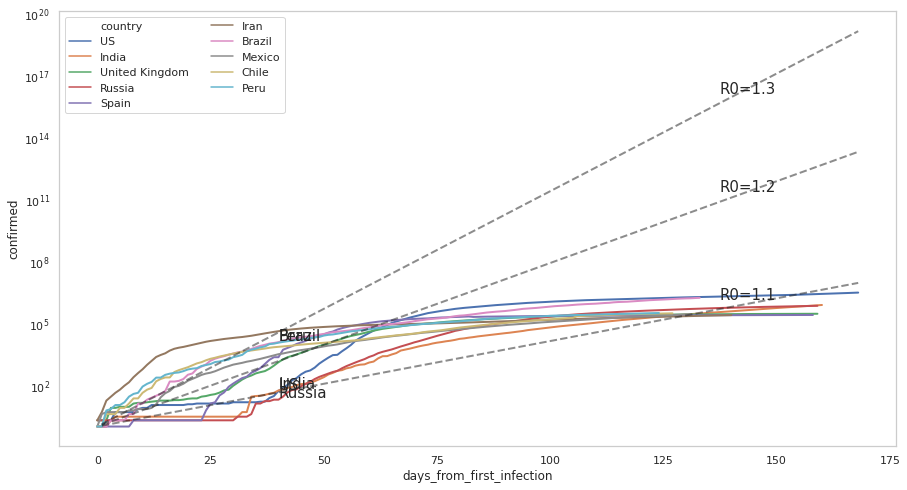

In [6]:
fig = plt.figure(figsize=(15,8))
ax = fig.subplots()

sns.lineplot(
    data=plot_df, 
    x='days_from_first_infection', 
    y='confirmed', 
    hue='country',
    lw=2
)

for country in selected_countries[:5]:
    cdf = plot_df[plot_df.country == country]
    loc = min(40, len(cdf)-1)
    row = cdf.iloc[loc]
    plt.text(row.days_from_first_infection, row.confirmed * 1.2, country, fontdict=dict(size=15))

x=np.linspace(1, global_df.days_from_first_infection.max())
def plot_rate(rate):
    y = rate ** x
    ax.semilogy(x, y, 'k--', lw=2, alpha=0.5)
    plt.text(x[40], y[40] * 3, f'R0={rate}', fontdict=dict(size=15))
    

plot_rate(1.1)
plot_rate(1.2)
plot_rate(1.3)
ax.grid()
plt.legend(loc='best', ncol=2);

# Tasa de contagios por país

El color corresponde con la cantidad de casos confirmados

In [7]:
today_df = global_df[
    (global_df.date == global_df.date.max()) & 
    (global_df.confirmed > 1000)
]


alt.Chart(today_df).mark_bar().encode(
    x=alt.X(
        'country', 
        sort=list(
            today_df.set_index('country')
                    .confirmed_growth_rate
                    .sort_values()
                    .index[::-1]
        )
    ),
    y=alt.X(
        'confirmed_growth_rate', 
        scale=alt.Scale(domain=[1, 1.6], clamp=True)
    ),
    color=alt.Color('confirmed', scale=alt.Scale(type='log')),
    tooltip=list(today_df.columns)
)

alt.Chart(...)